# Pyem comparison

In [15]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10

from src.utils import volume_fourier, mip_x, mip_z, create_mask
from src.projection import project
#from src.interpolate import *

In [3]:
from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

### The volume

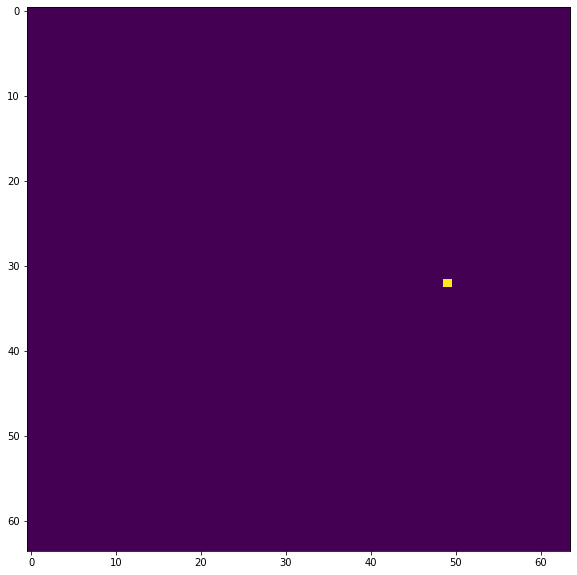

In [4]:
nx = 64
dx = 0.2

vol = np.zeros([nx,nx,nx])
vol[32,49,32] = 1

vol_pyem = np.zeros([nx,nx,nx])
vol_pyem[32,32,49] = 1

mip_x(vol_pyem)

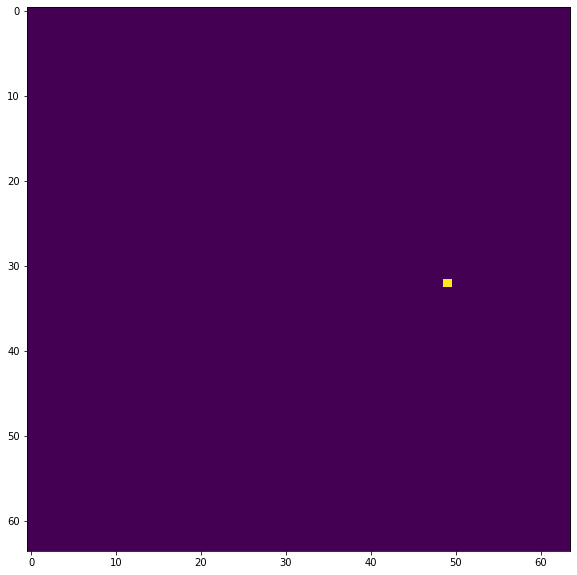

In [5]:
mip_z(vol)

In [6]:
# f3d : Fourier volume (centred, Nyquist-limited, zero-padded (pfac=2), normalized (normfft=1) interpolation-ready 3D Fourier transform)

pfac = 1
f3d_pyem = vop.vol_ft(vol_pyem, pfac=pfac, threads=1)
#plt.imshow(np.real(f3d_pyem[:,:,3])); plt.colorbar()

### Pyem projection

Parameters from the star file:

https://relion.readthedocs.io/en/release-3.1/Reference/Conventions.html?highlight=star#star-format

In [9]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
i, p = next(dfiter)
#i, p = next(dfiter)

#p["rlnVoltage"] = 0
#p["rlnSphericalAberration"]
p[star.Relion.ORIGINX] = 0
p[star.Relion.ORIGINY] = 0

# These don't seem to make any difference here. These replaced rlnOriginX and rlnOriginY (pixels) in Relion 3.1
p[star.Relion.ORIGINXANGST] = 0
p[star.Relion.ORIGINYANGST] = 0

#p[star.Relion.ANGLEROT] = -30.0 # Around the z axis (first axis)
#p[star.Relion.ANGLETILT] = 77.14285714285714 # Around the new y axis 
#p[star.Relion.ANGLEPSI] = -594.0 # Arond the new z axis

p[star.Relion.ANGLEROT] = 0 # Around the z axis (first axis)
p[star.Relion.ANGLETILT] = 0 # Around the new y axis 
p[star.Relion.ANGLEPSI] = 0 # Arond the new z axis

p["rlnSphericalAberration"] = 0
p["rlnAmplitudeContrast"] = 0

#p[star.Relion.DEFOCUSU] = 0
#p[star.Relion.DEFOCUSV] = 0
#p[star.Relion.DEFOCUSANGLE] = 0


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


In [10]:
#pfac = 2

size = (f3d_pyem.shape[0] - 3) // pfac
#size = 131


sz = (f3d_pyem.shape[0] - 3) // pfac
#sz = size
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

f2d_pyem = project_pyem(f3d_pyem, p, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)


ift = irfft2(f2d_pyem.copy(), threads=1, planner_effort="FFTW_ESTIMATE", auto_align_input=True, auto_contiguous=True)
proj_pyem = np.fft.fftshift(ift(f2d_pyem.copy(), np.zeros(ift.output_shape, dtype=ift.output_dtype)))

#plt.imshow(np.real(f2d_pyem)); plt.colorbar()
print(f2d_pyem.shape)

(64, 33)


### My projection

In [11]:
print(-360-1.3*180)
print(3*180/7)
print(-180/6)

-594.0
77.14285714285714
-30.0


In [12]:
# Pixel size - here we multiply by 64/66 to match the 'effective pixel size' in pyem, 
# where the image is padded with 3 additional rows/columns (in addition to the padding)
pixel_size = star.calculate_apix(p) * 64.0/66.0

f3d, X, Y, Z = volume_fourier(np.fft.ifftshift(vol), pixel_size)

#mymask = create_mask(X,Y,Z, (0,0,0), np.max(X))
#f3d = f3d * mymask

x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# IMPORTANT: do not make this a Jax array
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

#angles = [-2*np.pi-1.3*np.pi,3*np.pi/7,-np.pi/6]
angles = [0,0,0] # third angle is rotation around the first z axis
#shifts = np.array([17.0, -35.0]) * pixel_size

shifts = [0.0, 0.0]

In [13]:
ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
              'def2'  : p[star.Relion.DEFOCUSV],
              'angast': p[star.Relion.DEFOCUSANGLE], 
              'phase' : p[star.Relion.PHASESHIFT],
              'kv'    : p[star.Relion.VOLTAGE],
              'ac'    : p[star.Relion.AC], 
              'cs'    : p[star.Relion.CS], 
              'bf'    : 0,
              'lp'    : 2 * pixel_size}

In [47]:
f2d, coords_slice = project(f3d, x_grid, y_grid, z_grid, angles, shifts, 'tri', None)
f2d = f2d.reshape(f3d.shape[0], f3d.shape[1])
#f2d = np.fft.fftshift(f2d)

In [48]:
proj = np.real(np.fft.fftshift(np.fft.ifftn(f2d)))

In [49]:
np.sum(np.abs(np.imag(np.fft.fftshift(np.fft.ifftn(f2d)))))

2.711903742130898e-14

### Compare

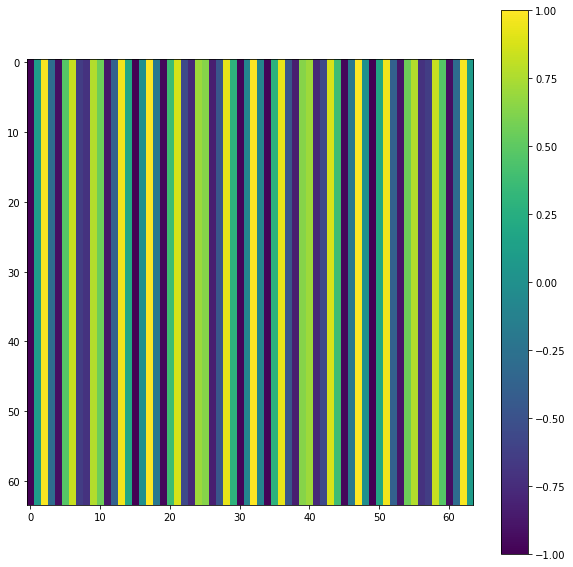

In [50]:
plt.imshow(np.fft.fftshift(np.real(f2d))); plt.colorbar()

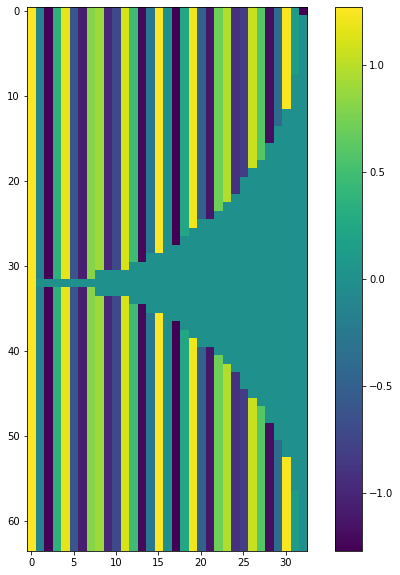

In [51]:
plt.imshow(np.real(f2d_pyem)); plt.colorbar()

### Compute the full FFT of the pyem object so I can fftshift it and see if it makes sense.

In [52]:
f2d_pyem_full = np.zeros(f2d.shape, dtype = f2d_pyem.dtype)
f2d_pyem_full[:,0:33] = f2d_pyem

for k1 in range(64):
    for k2 in range(32,64):
        if k1 == 0:
            kk1 = 0
        else: 
            kk1 = 64-k1
            
        if k2 == 0:
            kk2 = 0
        else:
            kk2 = 64-k2
            
        f2d_pyem_full[k1,k2] = np.conj(f2d_pyem[kk1, kk2])

0.0

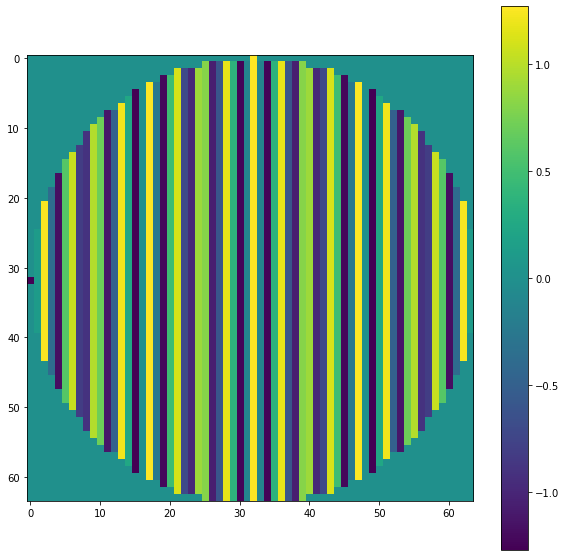

In [53]:
plt.imshow(np.real(np.fft.fftshift(f2d_pyem_full))); plt.colorbar()
np.sum(np.abs(np.imag(np.fft.fftshift(np.fft.ifftn(f2d_pyem_full)))))

In [54]:
fs = np.fft.fftshift(f2d)
fs[0,0]

(-1+0j)

1.000000000000007


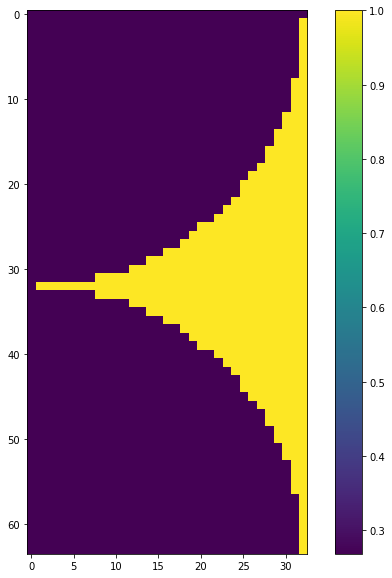

In [25]:
diff = np.array(f2d[:,0:33] - f2d_pyem)

plt.imshow(np.abs(diff)); plt.colorbar()
print(np.max(np.abs(diff)))


0.26840666736692115


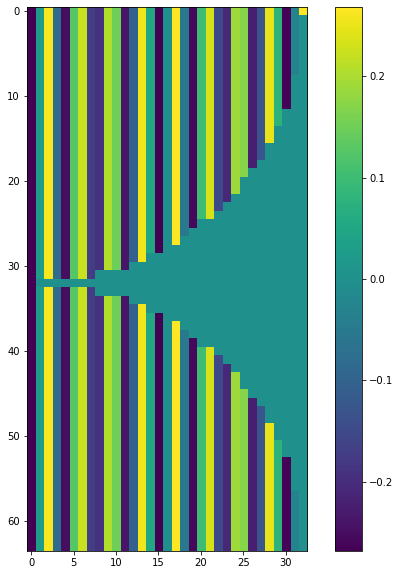

In [26]:
diff[np.abs(diff) > 0.6] = 0
plt.imshow(np.real(diff)); plt.colorbar()

print(np.max(np.abs(diff)))

1.000000000000007


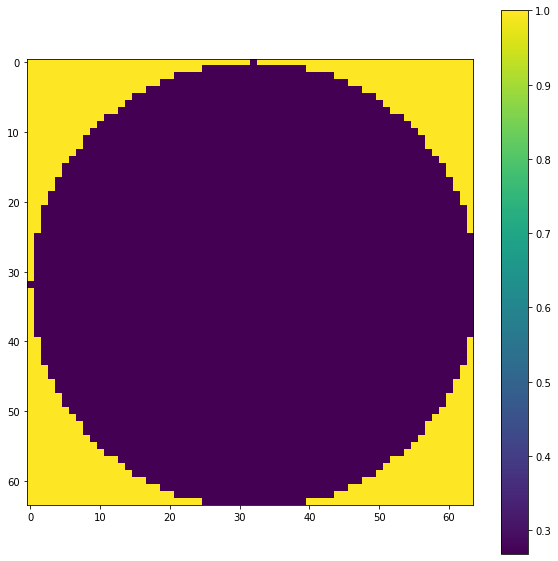

In [27]:
diff_full = np.array(f2d - f2d_pyem_full)

plt.imshow(np.abs(np.fft.fftshift(diff_full))); plt.colorbar()
print(np.max(np.abs(diff_full)))

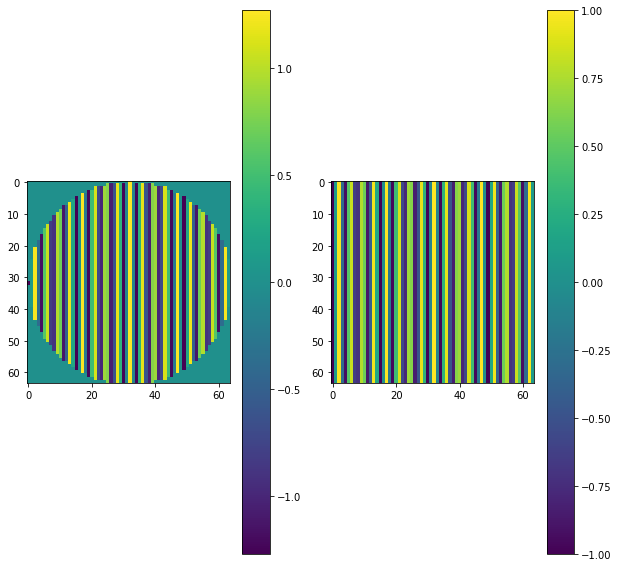

In [28]:
plt.subplot(1,2,1)
plt.imshow(np.real(np.fft.fftshift(f2d_pyem_full))); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.fft.fftshift(np.real(f2d))); plt.colorbar()

0.26840666736692115


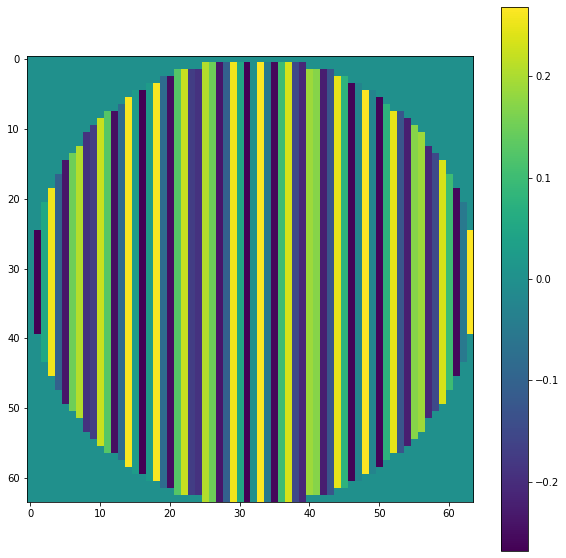

In [29]:
diff_full[np.abs(diff_full) > 0.6] = 0
plt.imshow(np.imag(np.fft.fftshift(diff_full))); plt.colorbar()

print(np.max(np.abs(diff_full)))

In [30]:
diff_full_shifted = np.fft.fftshift(diff_full)
f2d_shifted = np.fft.fftshift(f2d)
f2d_pyem_full_shifted = np.fft.fftshift(f2d_pyem_full)

d = np.zeros(64, dtype = np.complex128)
f = np.zeros(64, dtype = np.complex128)
fpyem = np.zeros(64, dtype = np.complex128)
for i in range(64):
    d[i] = diff_full_shifted[63-i,i]    
    f[i] = f2d_shifted[63-i,i]
    fpyem[i] = f2d_pyem_full_shifted[63-i,i]

In [31]:
f2d0 = np.fft.fftshift(f2d)
f0 = f2d[0,:]

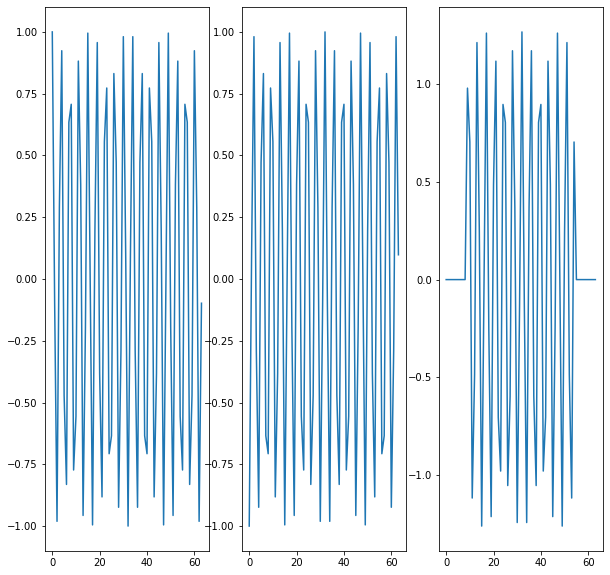

In [32]:
plt.subplot(1,3,1)
plt.plot(np.real(f0))
plt.subplot(1,3,2)
plt.plot(np.real(f))
plt.subplot(1,3,3)
plt.plot(np.real(fpyem))

### The pyEM projection as given by FFTW using irfft

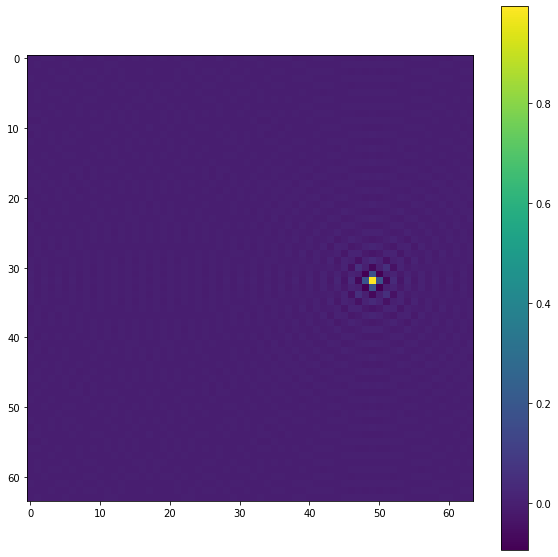

In [33]:
plt.imshow(proj_pyem); plt.colorbar()

### The projection using my code

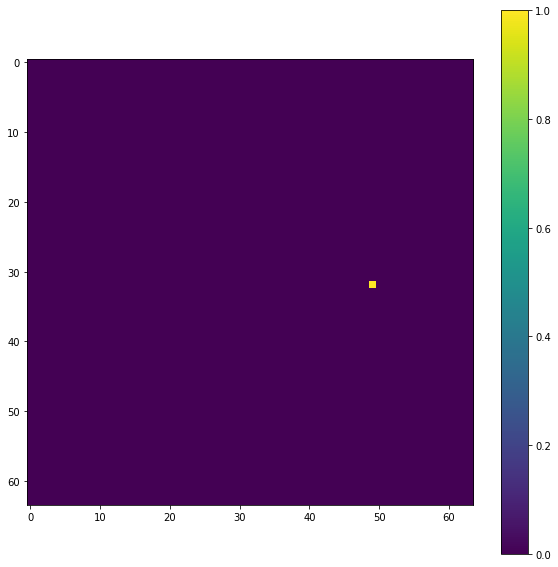

In [34]:
plt.imshow(proj); plt.colorbar()

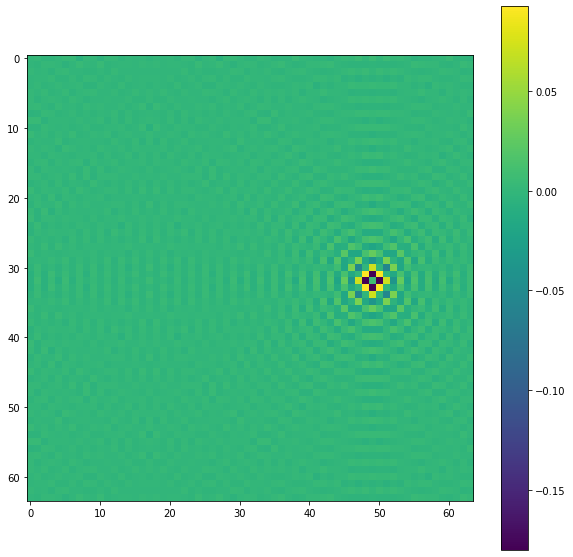

In [35]:
plt.imshow(proj-proj_pyem); plt.colorbar()

### Projection using the pyEM Fourier slice + manual completion of the fft + numpy ifft

In [36]:
proj_pyem_full = np.fft.fftshift(np.fft.ifftn(f2d_pyem_full))

print(np.sum(np.abs(np.imag(proj_pyem_full))))

#proj_pyem_full = np.real(proj_pyem_full)

0.0


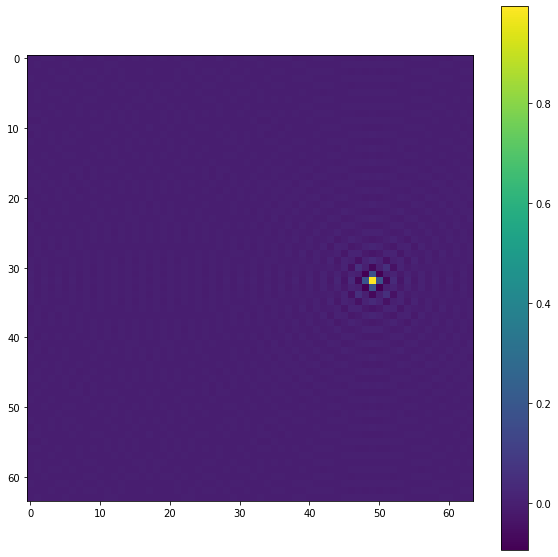

In [37]:
plt.imshow(np.real(proj_pyem_full)); plt.colorbar()

### Sanity check - the pyEM projection agrees with the completed pyEM slice

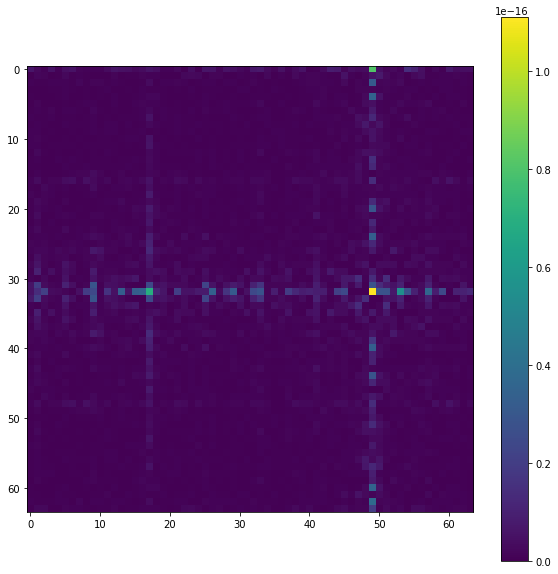

In [38]:
plt.imshow(np.abs(proj_pyem.astype(np.complex128)-proj_pyem_full)); plt.colorbar()